In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"olgaikitina","key":"cc00ece00b8848f0613cd5222ecad502"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle competitions download -c hse-nlp-bootcamp-dl-track

 99% 247M/250M [00:14<00:00, 21.7MB/s]
100% 250M/250M [00:14<00:00, 18.6MB/s]


In [5]:
!unzip -q /content/hse-nlp-bootcamp-dl-track.zip
!rm /content/hse-nlp-bootcamp-dl-track.zip

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [109]:
df = pd.read_csv('train_dl.csv')
df.head()

,bank,feeds,grades,date
0,unicreditbank,Я очень редко пользуюсь банковскими продуктами...,5.0,31.12.2017 18:20
1,fk_otkritie,Я вместе с женой 15.11.2019 обратился в отделе...,1.0,22.11.2019 22:42
2,alfabank,Добрый день.Сегодня 27.12.2018 г около 15.40-1...,1.0,27.12.2018 23:20
3,vtb,"""Где карточку открывали, туда и идите..."" - эт...",2.0,05.02.2020 16:40
4,promsvyazbank,При покупках в iTunes списываются завышенные с...,NaN,26.02.2016 15:48


In [110]:
df = df.dropna()
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M')
df = df[df['date'] > '2009-01-01 00:00:00']

In [113]:
df.groupby('grades').count()

,bank,feeds,date
grades,,,
1.0,129814,129814,129814
2.0,25803,25803,25803
3.0,11131,11131,11131
4.0,7094,7094,7094
5.0,66408,66408,66408


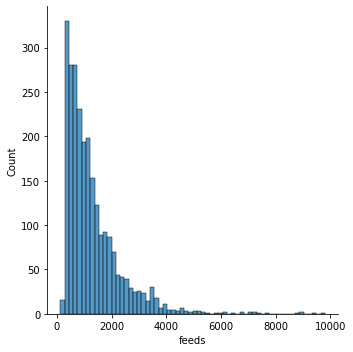

In [116]:
g = sns.displot(df['feeds'].apply(len))

In [10]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 95.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 114.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.9 MB/s eta 0:00:00


In [5]:
import torch
import transformers
import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [118]:
max_len = 951
tokenized = df['feeds'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, 
                                                                      truncation=True, 
                                                                      max_length=max_len,
                                                                      pad_to_max_length=True,
                                                                      ))

In [119]:
padded = np.array([i for i in tokenized.values])

In [120]:
attention_mask = np.where(padded != 0, 1, 0)

In [121]:
input_ids = torch.tensor(padded)  
attention_masks = torch.tensor(attention_mask)

In [122]:
from torch.utils.data import TensorDataset
dataset = TensorDataset(input_ids, attention_masks)

In [123]:
from torch.utils.data import DataLoader

batch_size = 16

dataloader = DataLoader(
            dataset,
            batch_size = batch_size 
        )

In [ ]:
all_last_hidden_states = 1
with torch.inference_mode():
  for step, batch in enumerate(dataloader):
    input_ids, attention_mask = batch
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
    if not torch.is_tensor(all_last_hidden_states):
      all_last_hidden_states = last_hidden_states.last_hidden_state
    else:
      all_last_hidden_states = torch.cat((all_last_hidden_states, last_hidden_states.last_hidden_state), dim=0)


In [126]:
all_last_hidden_states.shape

torch.Size([2500, 951, 312])

In [127]:
vectors = all_last_hidden_states[:,0,:].numpy()

In [128]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
labels = le.fit_transform(df['grades'])

In [129]:
train_features, test_features, train_labels, test_labels = train_test_split(vectors, labels)

In [131]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(train_features, train_labels)
gb_clf.score(test_features, test_labels)

0.416

Not finished, next step is to find hyperparameters for clasificators 